In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pickle
from scipy.optimize import linprog
import pandas as pd
import time

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) 
gridSize = 6 
state_count = gridSize*gridSize

In [3]:
class Invader_Defender():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        
        # deterministic transition ?
        self.transition_prob = 1 
        
        # initialize defender and invader states
        self.new_state = [0, 0, 0, 0]
        self.new_defender_state = [0, 0]
        self.new_invader_state = [0, 0]
        
        # set territory state
        self.territory_state = [4, 4]

        # create a list of all possible states in the game
        self.game_state_list = []
        for defender_state in self.states:
            for invader_state in self.states:
                combined_states = tuple(defender_state + invader_state)
                self.game_state_list.append(combined_states)
        
        # create 2 lists of states representing defender and invader victory
        self.defender_won = []
        self.invader_won = []
        
        # create states representing defender victory
        for defender_state in self.states:
            for invader_state in self.states:
                distance = np.linalg.norm(np.array(defender_state) - np.array(invader_state))
                # if the invader is not at territory and within the capture range of defender = defender won
                if invader_state != self.territory_state and distance <= np.sqrt(2):
                    combined_states = defender_state + invader_state
                    self.defender_won.append(combined_states)
           
        # create states representing invader victory = anytime invader is at territory
        for defender_state in self.states:               
            combined_states = defender_state + self.territory_state
            self.invader_won.append(combined_states)
    
    def possible_states(self):
        """
        A function that returns a list of all possible states in the game
        """
        return self.game_state_list
    
    def terminal_check(self, state):
        """
        A function that checks whether the game is at a terminal state.
        Terminal state happens when either the invader or defender has won.
        """
        if state in self.defender_won:
            status = "Defender Won"
            terminal_check = True
        elif state in self.invader_won:
            status = "Invader Won"
            terminal_check = True
        else:
            terminal_check = False
            status = "Game in Progress"
            
        return terminal_check, status
    
    #     def transition_probability(self, transition):
#         """
#         A function that returns the transition probability...?
#         """
#         return self.transition_prob, reward

    def next_state(self, current_state, defender_action, invader_action):
        """
        A function that returns the next state
        Input: current state [0,0] , defender_action [0, 1], invader_action [0,-1]
        Output: next state array([x1,y1,x2,y2]) and reward (int)
            - If the action takes the agent off grid, the agent remains in original state
            - If defender won, reward is calculated based on manhattan distance between invader captured state
            and territory
            - If defender loss, reward is -100
        """
        defender_state = []
        invader_state = []
        
        # deconstruct current state [0,0,1,1] in to defender [0,0] and invader [1,1] state
        for i in range(4):
            if i < 2:
                defender_state.append(current_state[i])
            else:
                invader_state.append(current_state[i])
                
        # get next state: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_defender_state = list(np.array(defender_state) + np.array(defender_action))
        self.new_invader_state = list(np.array(invader_state) + np.array(invader_action))

        # if new defender states results in off the grid, return to original state
        if -1 in self.new_defender_state or self.size in self.new_defender_state:
            self.new_defender_state = defender_state
        
        # if new invader states results in off the grid, return to original state
        if -1 in self.new_invader_state or self.size in self.new_invader_state:
            self.new_invader_state = invader_state
       
        # combine the defender and invader state
        self.new_state = self.new_defender_state
        self.new_state.extend(self.new_invader_state)
        
        # new rewards: penalizing defender for every step that invader takes closer to territory
        terminal, status = self.terminal_check(self.new_state)
        if terminal == True:
            if status == "Defender Won":
                # defender reward if defender won (manhattan distance between invader captured state and territory)
                distance_to_territory = sum(abs(np.array(self.new_invader_state) - np.array(self.territory_state)))
                self.reward = distance_to_territory * 10
            else:
                # defender reward if invader won
                self.reward = -1000
        else:
            # penalize defender for every step that invader takes closer to territory
            invader_to_territory = sum(abs(np.array(self.new_invader_state) - np.array(self.territory_state)))
            self.reward = -(8 - invader_to_territory)*10
            
        return self.new_state, self.reward

### Initialization and Function Definitions

In [4]:
invader_defender = Invader_Defender(6)

In [5]:
k = 0
U = {}
gamma = 0.9
state_list = []
listofzeros = [0.0] * len(invader_defender.game_state_list)
delta_list = []

# convert game_state_list in to a state list of tuples in order to make a dictionary
for state in invader_defender.game_state_list:
    state_list.append(state)
    
# initiate params
G = dict(zip(state_list, listofzeros))
U[k] = dict(zip(state_list, listofzeros))

In [6]:
# initialize policies
initial_policy = []
for i in range(len(invader_defender.game_state_list)):
    random_policy = np.array([0.25, 0.25, 0.25, 0.25])
    initial_policy.append(random_policy)
defender_policy = dict(zip(state_list, initial_policy))
invader_policy = dict(zip(state_list, initial_policy))

In [7]:
def calculate_payoff(state):
    """
    A function calculates the payoff of a specific state by iterating over every defender/invader action
    Input: state (ie. [0,0,1,1])
    Output: payoff = 4x4 matrix where each element represent the defender's payoff 
    when defender take i, and invader take action j
    """
    state = list(state)
    payoff = np.zeros([4,4])
    for i in range(action_count):
        defender_action = actions[i]
        for j in range(action_count):
            invader_action = actions[j]
            next_state, reward = invader_defender.next_state(state, defender_action, invader_action)
            payoff[i, j] = reward + gamma*invader_defender.transition_prob*U[k][tuple(next_state)]
    return payoff

In [8]:
def calculate_value(G_state):
    """
    A function that calculates the value of a game by using linear programming.
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: Value = scalar value of the game.
    """
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # check if the linprog solution is successful or not
    if defender_solution['status'] == 0:
        value = defender_solution['fun']*-1
    else:
        value = invader_solution['fun'] 
    
    return value

In [9]:
def equilibrium(G_state):
    """
    A function that obtains the policy for defender and invader
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: policy for defender and invader
    """
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    defender_policy = defender_solution['x'][:4]
    invader_policy = invader_solution['x'][:4]
    
    return defender_policy, invader_policy

### Shapley's Value Iteration

In [10]:
# to remove warnings
import warnings
warnings.filterwarnings('ignore')

tolerance = 1e-6
delta = 1
k = 0

last_delta = 1000

while delta > tolerance:
   
    delta = 0
    
    # initialize the next entry of the U dictionary
    U[k+1] = dict(zip(state_list, listofzeros))

    for state in invader_defender.game_state_list:
        
        # Build G dictionary {state: payoff (4x4)}
        G[state] = calculate_payoff(state)

        # calculate value of game
        value = calculate_value(G[state])

        # write value of game to the dictionary
        U[k+1][state] = value

        # calculate delta
        delta = max(delta, abs(U[k+1][state]-U[k][state]))
        
    # print k and current max delta
    clear_output(wait=True)
    display('k: ' + str(k) + ' delta: ' + str(delta))
    
    delta_list.append(delta)
    k += 1
    
    # stop training when delta explodes
    if delta > last_delta:
        break
    
    last_delta = delta

'k: 197 delta: 9.677783054939937e-07'

In [11]:
# policy extraction
# defender_policy = {}
# invader_policy = {}

for state in invader_defender.game_state_list:  
    G[state] = calculate_payoff(state)
    defender_policy[state], invader_policy[state] = equilibrium(G[state])

### Plot Delta

Text(0, 0.5, 'Delta')

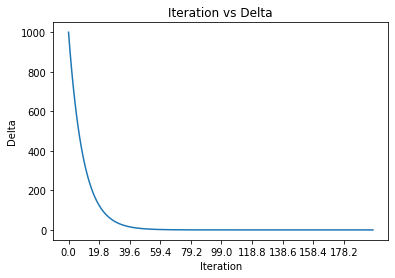

In [12]:
plt.plot(delta_list)
plt.title('Iteration vs Delta')
plt.xlabel('Iteration')
plt.xticks(np.arange(0, k, k/10))
plt.ylabel('Delta')

### Defender/Invader Policy

In [13]:
defender_policy

{(0,
  0,
  0,
  0): array([ 1.00000000e+00,  0.00000000e+00,  3.76182238e-14, -3.75072015e-14]),
 (0,
  0,
  0,
  1): array([0.00000000e+00, 1.00000000e+00, 2.10828912e-15, 0.00000000e+00]),
 (0,
  0,
  0,
  2): array([ 0.00000000e+00,  1.00000000e+00, -1.11022302e-16,  0.00000000e+00]),
 (0, 0, 0, 3): array([0., 1., 0., 0.]),
 (0, 0, 0, 4): array([0., 1., 0., 0.]),
 (0, 0, 0, 5): array([0., 1., 0., 0.]),
 (0,
  0,
  1,
  0): array([0.00000000e+00, 3.18032677e-17, 1.00000000e+00, 0.00000000e+00]),
 (0, 0, 1, 1): array([0. , 0.5, 0.5, 0. ]),
 (0, 0, 1, 2): array([0., 0., 1., 0.]),
 (0,
  0,
  1,
  3): array([0.00000000e+00, 1.00000000e+00, 1.11022302e-16, 0.00000000e+00]),
 (0, 0, 1, 4): array([0., 1., 0., 0.]),
 (0, 0, 1, 5): array([0.        , 0.17577603, 0.82422397, 0.        ]),
 (0,
  0,
  2,
  0): array([0.00000000e+00, 2.22044605e-16, 1.00000000e+00, 0.00000000e+00]),
 (0, 0, 2, 1): array([0., 1., 0., 0.]),
 (0, 0, 2, 2): array([0., 1., 0., 0.]),
 (0, 0, 2, 3): array([0., 1., 0.

In [14]:
invader_policy

{(0, 0, 0, 0): array([0., 1., 0., 0.]),
 (0,
  0,
  0,
  1): array([0.00000000e+00, 1.25965896e-16, 1.00000000e+00, 0.00000000e+00]),
 (0,
  0,
  0,
  2): array([0.00000000e+00, 1.00000000e+00, 2.22044605e-16, 0.00000000e+00]),
 (0, 0, 0, 3): array([0., 1., 0., 0.]),
 (0, 0, 0, 4): array([0., 0., 1., 0.]),
 (0, 0, 0, 5): array([0., 0., 1., 0.]),
 (0,
  0,
  1,
  0): array([-3.94430453e-31,  1.00000000e+00,  3.33066907e-16,  0.00000000e+00]),
 (0,
  0,
  1,
  1): array([1.11022302e-16, 5.00000000e-01, 5.00000000e-01, 0.00000000e+00]),
 (0, 0, 1, 2): array([0., 1., 0., 0.]),
 (0,
  0,
  1,
  3): array([0.00000000e+00, 1.00000000e+00, 1.11022302e-16, 0.00000000e+00]),
 (0, 0, 1, 4): array([0., 0., 1., 0.]),
 (0,
  0,
  1,
  5): array([0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.11022302e-16]),
 (0, 0, 2, 0): array([0., 0., 1., 0.]),
 (0, 0, 2, 1): array([0., 1., 0., 0.]),
 (0, 0, 2, 2): array([0., 1., 0., 0.]),
 (0,
  0,
  2,
  3): array([0.00000000e+00, 1.00000000e+00, 1.11022302e-

### Save Results to Pickle

In [15]:
# takes ~ 50 minutes (175 iterations) to converge to within tolerance, 
# so I am saving the learned U and G as a pickle
# to load them up faster (for development purpose)

with open('U_valueiteration.pickle', 'wb') as handle:
    pickle.dump(U, handle)

with open('G_valueiteration.pickle', 'wb') as handle:
    pickle.dump(G, handle)
# # uncomment to load U and G

# with open ('U_valueiteration.pickle', 'rb') as handle:
#     U = pickle.load(handle)
    
# with open ('G_valueiteration.pickle', 'rb') as handle:
#     G = pickle.load(handle)

# # converged k. This gives the last update to U dict
# k = 175

# # initialize policies
# defender_policy = {}
# invader_policy = {}
# state_counter = 0

# # policy extraction
# for state in invader_defender.game_state_list:    
#     G[state] = calculate_payoff(state)
#     defender_policy[state], invader_policy[state] = equilibrium(G[state])
#     state_counter += 1
#     clear_output(wait=True)
#     display('State: ' + str(state_counter))

### Heatmap

In [16]:
# create a list of states that fixes the defender's starting position
fixed_defender_state_list = []
for invader_state in invader_defender.states:
    fixed_defender_state = tuple([5, 0] + invader_state)
    fixed_defender_state_list.append(fixed_defender_state)

# create invader heatmap
invader_map = np.zeros([6,6])
for state in fixed_defender_state_list:
    invader_map[state[2], state[3]] = U[k][state]*-1 # -1 for invaders perspective

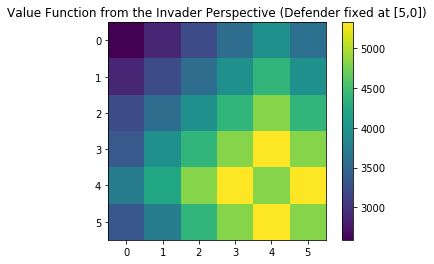

In [17]:
# if the defender is fixed at the bottom left corner, this heatmap shows the invader's rewards
plt.imshow(invader_map, interpolation='nearest')
plt.colorbar()
plt.title('Value Function from the Invader Perspective (Defender fixed at [5,0])')
plt.show()

In [18]:
# create a list of states that fixes the invaders's starting position
fixed_invader_state_list = []
for defender_state in invader_defender.states:
    fixed_invader_state = tuple(defender_state + [0, 0])
    fixed_invader_state_list.append(fixed_invader_state)

# create invader heatmap
defender_map = np.zeros([6,6])
for state in fixed_invader_state_list:
    defender_map[state[0], state[1]] = U[k][state]

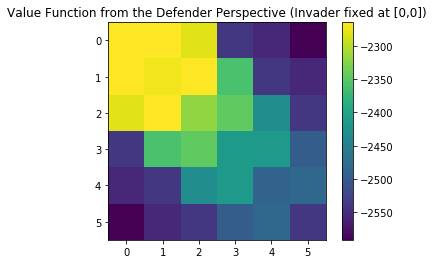

In [19]:
# if invader is fixed at top left corner, this heatmap shows the defender's rewards
plt.imshow(defender_map, interpolation='nearest')
plt.colorbar()
plt.title('Value Function from the Defender Perspective (Invader fixed at [0,0])')
plt.show()

### Play a game

In [25]:
def generate_trajectory(Defender_state, Invader_state):
    terminal = False
    generated = False
    
    # while not successful generation, repeat
    while not generated:
        game_step = 0
        current_state = tuple(Defender_state + Invader_state)
        game_trajectory = []
        # generate a game trajectory
        while not terminal:
            
            generated = True
            
            # append game trajectory
            game_trajectory.append(current_state)

            # check if game is terminal (someone won)
            terminal, status = invader_defender.terminal_check(list(current_state))

            # both agents choose action based on policy via sampling
            invader_action = actions[int(np.random.choice(action_count, 1, p=invader_policy[tuple(current_state)].clip(0)))]
            defender_action = actions[int(np.random.choice(action_count, 1, p=defender_policy[tuple(current_state)].clip(0)))]

            # obtain next state
            next_state, reward = invader_defender.next_state(list(current_state), defender_action, invader_action)
            current_state = tuple(next_state)

            game_step += 1
            clear_output(wait=True)
            display("game step: " + str(game_step))
            
            # exit the game if the game steps increase pass 100 (implying agents are stuck)
            if game_step > 200:
                generated = False
                break
    
    return game_trajectory, status

### Animate the Game

In [26]:
# generate game trajectory
game_trajectory, status = generate_trajectory([5,0],[0,0])

'game step: 7'

In [32]:

# define game dimensions
columns=range(invader_defender.size)
index = range(invader_defender.size)

# animate the game
for step in range(len(game_trajectory)):
    game_table = pd.DataFrame(0, index = index, columns=columns)
    game_table[4][4] = 'Ter.'
    game_table[game_trajectory[step][1]][game_trajectory[step][0]] = 'DEF'
    game_table[game_trajectory[step][3]][game_trajectory[step][2]] = 'INV'
    clear_output(wait=True)
    display(game_table)
    time.sleep(0.25)
    
# print game status
display(status)

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,DEF,INV,0
3,0,0,0,0,0,0
4,0,0,0,0,Ter.,0
5,0,0,0,0,0,0


'Defender Won'